In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import pandas as pd
import seaborn as sns

import csp_problems
import parser
import constraint
import os

In [2]:
path = 'logs/'
# filenames = os.listdir(path)

In [147]:
def decompose_filename(filename):
    info = {}
    decomp = filename.split('.')[0].split('_')
    info['solver'] = decomp.pop(0)
    info['problem_type'] = decomp.pop(0)
    info['problem_instance'] = '_'.join(decomp)
    info['filename'] = filename
    return info

def parse_info_filename(path, filename):
    with open(os.path.join(path, filename)) as file:
        input_data = file.read()
    lines = input_data.split('\n')[:-1]
    lines_type = [line.split('-')[0] for line in lines]
    calls = collections.Counter(lines_type)
    return calls

def get_dataframe(path):
    filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    infos = []
    for filename in filenames:
        if 'nrpa-1-100-heur-old' not in filename:
            info = decompose_filename(filename)
            calls = parse_info_filename(path, filename)
            infos.append({**info, **calls})
    return pd.DataFrame(infos)

In [148]:
def get_result_dataframe(filename, path='results'):
    with open(os.path.join(path,filename)) as file:
        data = file.read()
    filename_info = filename.split('.')[0].split('_')
    df = pd.read_json(data[:-1].replace("'", '"').replace('True', '"True"').replace('False', '"False"'), lines=True)
    df = df.replace({'solved': {'True': True, 'False': False}}).astype({'time':np.float32, 'solved':'bool'})
    df['problem']=filename_info[-2]
    df = df.loc[df['solver']!='nrpa-1-100-heur-old']
    return df

def get_result_dataframes(path='results'):
    filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    df = pd.concat([get_result_dataframe(filename, path) for filename in filenames], axis=0)
    return df

In [226]:
df = get_dataframe(path)
df.loc[df['problem_instance'].apply(lambda x: x.startswith('nqueens')), 'problem_instance'] = df.loc[df['problem_instance'].apply(lambda x: x.startswith('nqueens')), 'problem_instance'].apply(lambda x: x.split('_')[-1])
df.loc[df['problem_type'].apply(lambda x: x.startswith('nqueens')), 'problem_instance'] = df.loc[df['problem_type'].apply(lambda x: x.startswith('nqueens')), 'problem_type'] + '_' + df.loc[df['problem_type'].apply(lambda x: x.startswith('nqueens')), 'problem_instance']

results = get_result_dataframes()
results = results.rename(columns = {'filename':'problem_instance', 'problem':'problem_type'})
results = results.loc[results['solver']!='backtracking']
results.loc[results['problem_type']=='sudoku', 'problem_instance'] = results.loc[results['problem_type']=='sudoku', 'problem_instance'].apply(lambda x:'_'.join(list(str(x))))
results.loc[results['problem_instance'].apply(lambda x: x.startswith('nqueens')), 'problem_instance'] = results.loc[results['problem_instance'].apply(lambda x: x.startswith('nqueens')), 'problem_instance'].apply(lambda x: x.split('_')[-1])
results.loc[results['problem_type'].apply(lambda x: x.startswith('nqueens')), 'problem_instance'] = results.loc[results['problem_type'].apply(lambda x: x.startswith('nqueens')), 'problem_type'] + '_' + results.loc[results['problem_type'].apply(lambda x: x.startswith('nqueens')), 'problem_instance']

In [262]:
df = df.merge(results, how='outer', on=['solver', 'problem_type', 'problem_instance'])

In [263]:
df['problem_type'].value_counts()

coloring              72
sudoku                60
nqueens               24
nqueens-sym-simple    16
nqueens-sym           16
Name: problem_type, dtype: int64

In [264]:
df['solver'].value_counts()

nmcs-1             90
nrpa-1-100-heur    90
nmcs-2              8
Name: solver, dtype: int64

In [265]:
metrics = [col for col in df.columns if col.startswith('DEBUG')]

In [266]:
df.loc[df['DEBUG:root:end playout positive']>1]

,solver,problem_type,problem_instance,filename,DEBUG:root:nmcs call,DEBUG:root:assign,DEBUG:root:playout,DEBUG:root:end playout negative,DEBUG:root:end playout positive,time,solved


In [267]:
df.loc[df['solver'].isin(['nrpa-1-100-heur', 'nmcs-1'])].groupby(['problem_type', 'solver'])[metrics].sum()

DEBUG:root:nmcs call  DEBUG:root:assign  \
problem_type       solver                                                     
coloring           nmcs-1                       897661.0           897625.0   
                   nrpa-1-100-heur                   0.0                0.0   
nqueens            nmcs-1                           68.0               60.0   
                   nrpa-1-100-heur                   0.0                0.0   
nqueens-sym        nmcs-1                          543.0              535.0   
                   nrpa-1-100-heur                   0.0                0.0   
nqueens-sym-simple nmcs-1                           60.0               52.0   
                   nrpa-1-100-heur                   0.0                0.0   
sudoku             nmcs-1                       232747.0           232717.0   
                   nrpa-1-100-heur                   0.0                0.0   

                                    DEBUG:root:playout  \
problem_type       solver                                
coloring           nmcs-1                       897625   
                   nrpa-1-100-heur               25472   
nqueens            nmcs-1                           60   
                   nrpa-1-100-heur                  38   
nqueens-sym        nmcs-1                          535   
                   nrpa-1-100-heur                1341   
nqueens-sym-simple nmcs-1                           52   
                   nrpa-1-100-heur                  73   
sudoku             nmcs-1                       232717   
                   nrpa-1-100-heur               12675   

                                    DEBUG:root:end playout negative  \
problem_type       solver                                             
coloring           nmcs-1                                  897595.0   
                   nrpa-1-100-heur                          25453.0   
nqueens            nmcs-1                                      52.0   
                   nrpa-1-100-heur                             30.0   
nqueens-sym        nmcs-1                                     527.0   
                   nrpa-1-100-heur                           1334.0   
nqueens-sym-simple nmcs-1                                      44.0   
                   nrpa-1-100-heur                             65.0   
sudoku             nmcs-1                                  232694.0   
                   nrpa-1-100-heur                          12655.0   

                                    DEBUG:root:end playout positive  
problem_type       solver                                            
coloring           nmcs-1                                      11.0  
                   nrpa-1-100-heur                             17.0  
nqueens            nmcs-1                                       8.0  
                   nrpa-1-100-heur                              8.0  
nqueens-sym        nmcs-1                                       6.0  
                   nrpa-1-100-heur                              7.0  
nqueens-sym-simple nmcs-1                                       8.0  
                   nrpa-1-100-heur                              8.0  
sudoku             nmcs-1                                      17.0  
                   nrpa-1-100-heur                             19.0

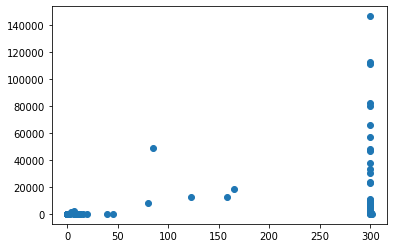

In [268]:
plt.scatter(df.loc[df['solver']=='nmcs-1', 'time'], df.loc[df['solver']=='nmcs-1', 'DEBUG:root:playout'])

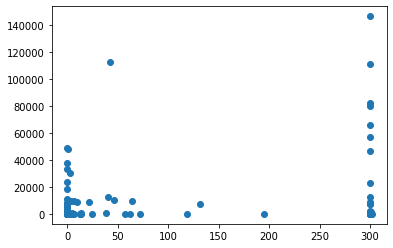

In [269]:
plt.scatter(df.loc[df['solver']=='nrpa-1-100-heur', 'time'], df.loc[df['solver']=='nmcs-1', 'DEBUG:root:playout'])

### Nb of playouts

In [283]:
grouped = df.loc[df['solver'].isin(['nrpa-1-100-heur', 'nmcs-1'])].groupby(['solver'])[metrics].mean()#.plot.bar()
grouped

,DEBUG:root:nmcs call,DEBUG:root:assign,DEBUG:root:playout,DEBUG:root:end playout negative,DEBUG:root:end playout positive
solver,,,,,
nmcs-1,12567.544444,12566.544444,12566.544444,14880.421053,1.0
nrpa-1-100-heur,NaN,NaN,439.988889,500.468354,1.0


In [284]:
grouped.stack().reset_index().rename(columns = {'level_1':'log_type', 0:'mean'}).set_index('log_type')

,solver,mean
log_type,,
DEBUG:root:nmcs call,nmcs-1,12567.544444
DEBUG:root:assign,nmcs-1,12566.544444
DEBUG:root:playout,nmcs-1,12566.544444
DEBUG:root:end playout negative,nmcs-1,14880.421053
DEBUG:root:end playout positive,nmcs-1,1.000000
DEBUG:root:playout,nrpa-1-100-heur,439.988889
DEBUG:root:end playout negative,nrpa-1-100-heur,500.468354
DEBUG:root:end playout positive,nrpa-1-100-heur,1.000000


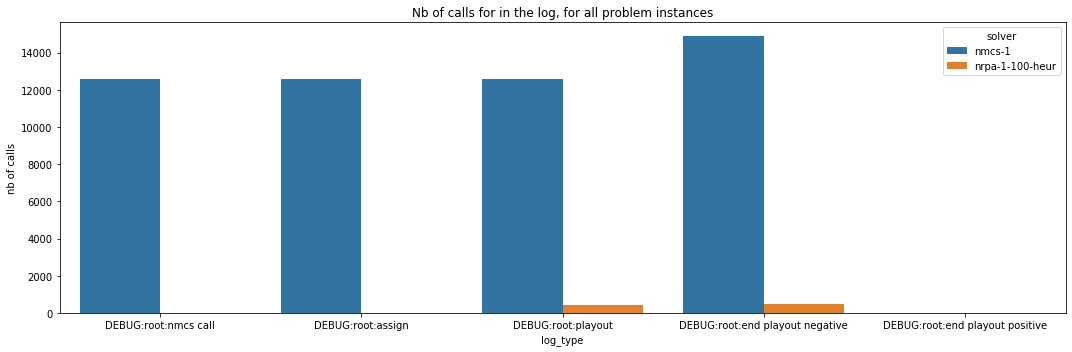

In [287]:
plt.figure(figsize=(15,5))
sns.barplot(x='log_type', y='sum', data=grouped.stack().reset_index().rename(columns = {'level_1':'log_type', 0:'sum'}), hue='solver')
plt.ylabel('nb of calls')
plt.title('Nb of calls for in the log, for all problem instances')

plt.tight_layout()
plt.savefig('log_calls_all_instances.png')
plt.show()

### Nb of playouts for solved instances

In [288]:
grouped = df.loc[df['solver'].isin(['nrpa-1-100-heur', 'nmcs-1']), ['solver', 'problem_instance', 'solved']].pivot(index='problem_instance', columns='solver', values='solved')
solved_indices = grouped[grouped.all(axis=1)].index

grouped = df.loc[(df['solver'].isin(['nrpa-1-100-heur', 'nmcs-1'])) & df['problem_instance'].isin(solved_indices)].groupby(['solver'])[metrics].mean()#.plot.bar()
grouped

,DEBUG:root:nmcs call,DEBUG:root:assign,DEBUG:root:playout,DEBUG:root:end playout negative,DEBUG:root:end playout positive
solver,,,,,
nmcs-1,1985.693878,1984.693878,1984.693878,2777.171429,1.0
nrpa-1-100-heur,NaN,NaN,107.693878,137.578947,1.0


In [289]:
grouped.stack().reset_index().rename(columns = {'level_1':'log_type', 0:'mean'}).set_index('log_type')

,solver,mean
log_type,,
DEBUG:root:nmcs call,nmcs-1,1985.693878
DEBUG:root:assign,nmcs-1,1984.693878
DEBUG:root:playout,nmcs-1,1984.693878
DEBUG:root:end playout negative,nmcs-1,2777.171429
DEBUG:root:end playout positive,nmcs-1,1.000000
DEBUG:root:playout,nrpa-1-100-heur,107.693878
DEBUG:root:end playout negative,nrpa-1-100-heur,137.578947
DEBUG:root:end playout positive,nrpa-1-100-heur,1.000000


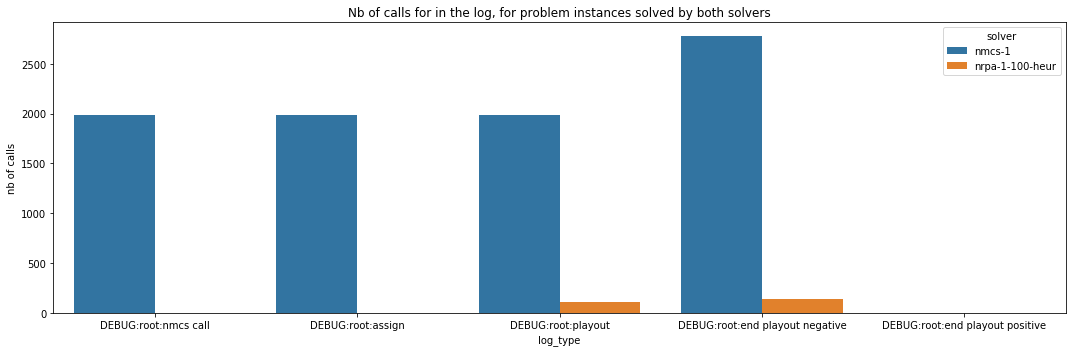

In [290]:
plt.figure(figsize=(15,5))
sns.barplot(x='log_type', y='sum', data=grouped.stack().reset_index().rename(columns = {'level_1':'log_type', 0:'sum'}), hue='solver')
plt.ylabel('nb of calls')
plt.title('Nb of calls for in the log, for problem instances solved by both solvers')

plt.tight_layout()
plt.savefig('log_calls_success_instances.png')
plt.show()